# Normalization

## Learning outcomes
**After having completed this chapter you will be able to:**

- Perform size normalization and log transformation of single-cell data.
- Intuitively understand what "normalization" does to your data
- Identifying highly variable gene features
- Perform data scaling
- Assign categorical cell cycle phases to single cells

In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

<button onclick="toggleVisibility('answer0')">Click for Answer</button>
<div id="answer0" style="display:none;">
<strong>Answer:</strong> Load your data from the previous notebook into an h5ad object with <code>sc.read_h5ad</code>
<pre>
    adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial.h5ad")
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script>
</div>

In [3]:
adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial.h5ad")

## Shift logarithm normalization

Each count in a count matrix represents the successful capture, reverse transcription and sequencing of a molecule of cellular mRNA. Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by e.g. scaling count data to obtain correct relative gene expression abundances between cells.

A recent benchmark published by [Ahlmann-Eltze and Huber (2023)](https://www.nature.com/articles/s41592-023-01814-1) compared 22 different transformations for single-cell data, which surprisingly showed that a seemingly simple shifted logarithm transformation outperformed gold-standard SCTransform (the default method in analysis package's such as Seurat in R).

We will thus use the shifted logarithm for normalizing our data, which is based on the delta method  v

$$f(y) = \log \left( \frac{y}{s} + y_0 \right) $$

with $y$ being the raw counts, $s$ being a so-called size factor and $y_0$ describing a pseudo-count. The size factors are determined for each cell to account for variations in sampling effects and different cell sizes. The size factor for a cell $c$ can be calculated by:

$$ s_c = \frac{\sum_g y_{gc}}{L} $$

with $g$ indexing different genes and $L$ describing a target sum. There are different approaches to determine the size factors from the data. We will leverage the scanpy default in this section with $L$ being the median raw count depth in the dataset. Many analysis templates use fixed values for $L$, for example $L = 10^6$, resulting in "counts per million" metric (CPM). For a beginner, these values may seem arbitrary, but it can lead to an overestimation of the variance. Indeed, [Ahlmann-Eltze and Huber (2023)](https://www.nature.com/articles/s41592-023-01814-1) showed that log(CPM+1) performed poorly on a variety of tasks.

The shifted logarithm is a fast normalization technique, outperforms other methods for uncovering the latent structure of the dataset (especially when followed by principal component analysis) and works beneficial for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

**Exercise 1:** Perform normalization using the logarithm shift, following the above formula. Without relying on `scanpy` implemented function, you should be able to compute the log-normalized data, and store the resulting matrix in the object `log_shifted_matrix` below. We then provide code to display the distribution of the raw counts versus the normalized data *_(exercise courtesy of Alexandre Coudray)_*.

<button onclick="toggleVisibility('answer1')">Click for Answer</button>
<div id="answer1" style="display:none;">
<strong>Answer:</strong>
<pre>
    median_raw_counts = np.median(adata.obs['n_counts'])
    size_factors = np.array(adata.obs['n_counts'] / median_raw_counts)
    log_shifted_matrix = np.log(adata.X / size_factors[:,None] + 1) # we use a pseudo-count of 1
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

## Visualize results and compare to scanpy normalization

Once you have performed the log-normalization shift, you can visualize your results here to see how the counts at `adata.X` have changed:

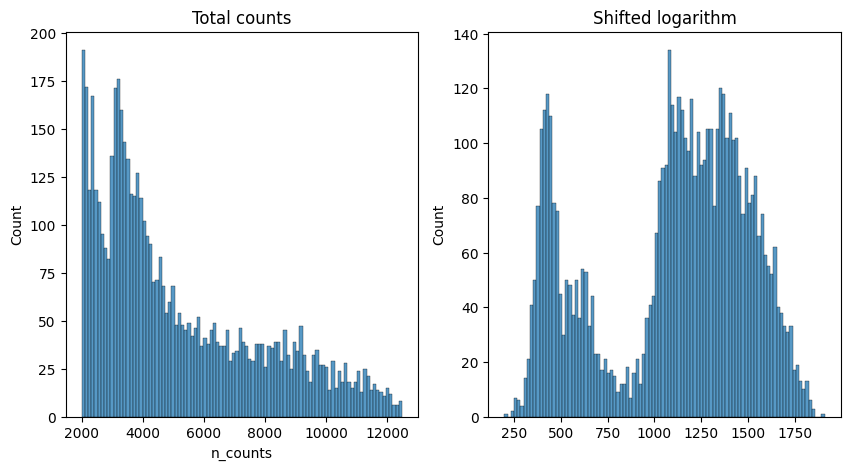

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["n_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(log_shifted_matrix.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

The shifted logarithm can be conveniently called with scanpy by running `pp.normalized_total` with `target_sum=None`. We then apply a log transformation with a pseudo-count of 1, which can be easily done with the function `sc.pp.log1p`.  

In [5]:
# This can be easily done with scanpy normalize_total and log1p functions
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform - log the data and adds a pseudo-count of 1
scales_counts = sc.pp.log1p(scales_counts["X"], copy=True)

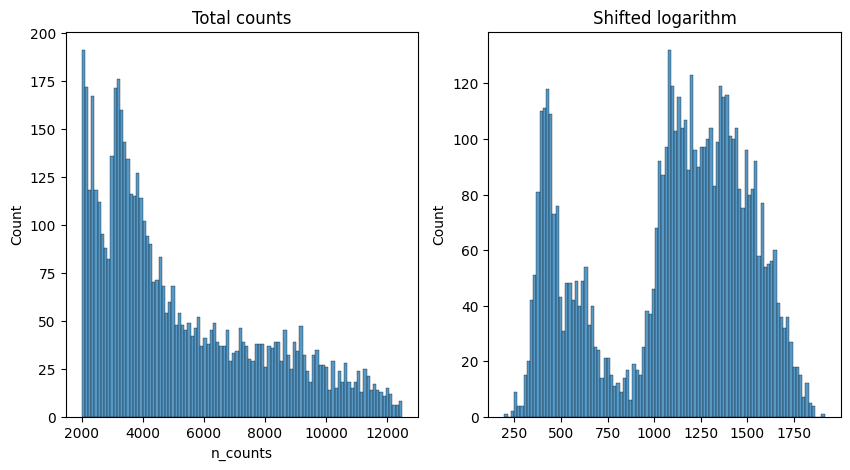

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["n_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(scales_counts.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

We verify that our normalization is the same as the one implemented in scanpy. You should have a corelation above 0.999999. The reason why we are not reaching a corelation of 1.0 comes from the precision in float number used by scanpy.

In [7]:
from scipy.stats import pearsonr

pearsonr(np.array(scales_counts).flatten(),
         np.array(log_shifted_matrix).flatten())

PearsonRResult(statistic=0.999998708385195, pvalue=0.0)

We then run the `normalized_total` and `log1p` functions it again so that the normalized data is set as our default matrix in `.X` emplacement.

Of course, in your own analysis, you can just use the two scanpy commands in the code cell above. However, this exercise aims as giving you a better understanding of the transformation being applied to your data! Some more complex machine learning based algorithms actually work more optimally on the raw, untransformed counts!

**Exercise 2**: Perform normalization and log transformation using the built in `scanpy` functions, as hinted at above.

<button onclick="toggleVisibility('answer2')">Click for Answer</button>
<div id="answer2" style="display:none;">
<strong>Answer:</strong>
<pre>
    # To directly change the data 'in place', use the following:
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

In [4]:
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)

## Cell cycle characterization and regression

Now, we begin with dimensionality reduction, i.e. reducing the number of variables in the data by removing features (genes) with little variability among the cells and by combining highly similar features. This is important because normally you start with tens of thousands of genes and it is difficult to represent their patterns in a two-dimensional visualization.

One useful (but optional) step is to perform cell cycle characterization, as the cell cycle signature is often a strong convoluting factor with cell type signatures.

**Exercise 3**: Perform cell cycle characterization on your dataset. Plot a scatter plot of the S_score and G2M_score metadata created and stored in your AnnData object. Color the points by the assigned cell cycle phase. What percentage of your cells are in a proliferative state (S or G2M phases)?

In [5]:
# your code here
S_genes_mouse = np.array(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG',
       'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'CENPU',
       'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76',
       'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2',
       'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2',
       'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'])
G2M_genes_mouse = np.array(['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A',
       'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF',
       'TACC3', 'PIMREG', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB',
       'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP',
       'CDCA3', 'JPT1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1',
       'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR',
       'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2',
       'G2E3', 'GAS2L3', 'CBX5', 'CENPA'])

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

The gene lists provided here are the "standard" in single cell analysis as come from the two papers:
- [Buettner et al (2015)](https://pubmed.ncbi.nlm.nih.gov/25599176/)
- [Satija et al (2015)](https://www.nature.com/articles/nbt.3192)

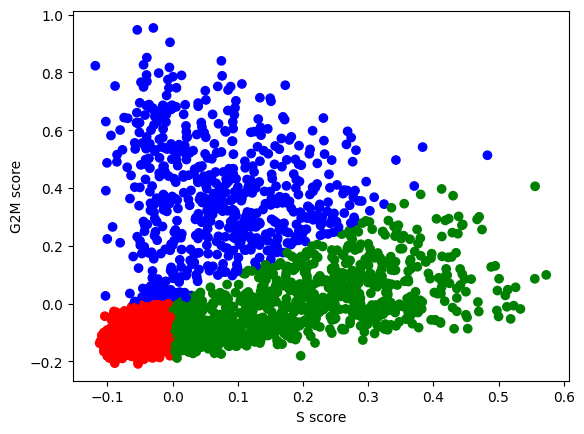

In [6]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=[n2c[k] for k in adata.obs['phase']])
plt.xlabel('S score') ; plt.ylabel('G2M score')
plt.show()

**Exercise 4**: How many cells do you have assigned to each of the cell cycle phases? Can you check this using a function you have applied in the previous exercises? What is the number of cells as a percentage of the total?

<button onclick="toggleVisibility('answer4')">Click for Answer</button>
<div id="answer4" style="display:none;">
  <strong>Answer:</strong> typing <code>adata.obs["phase"].value_counts()</code> should return:
  <pre>
    phase
    G1      3129
    S       1400
    G2M     940
    Name: count, dtype: int64
  </pre>
    You can then use <code>adata.n_obs</code> to divide the estimates by the total. You should get about:
  <pre>
    phase
    G1     0.592796
    S      0.249954
    G2M    0.157250
  </pre>
</div>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

## Highly variable gene selection

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). Genes that are similarly expressed in all cells will not assist with discriminating different cell types from each other.

The procedure in scanpy models the mean-variance relationship inherent in single-cell data, and is implemented in the `sc.pp.highly_variable_genes` function. By default, 2,000 genes (features) per dataset are returned and these will be used in downstream analysis, like PCA.

In [11]:
# suggestion: start with 3000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

In [12]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

While correcting for technical covariates may be crucial to uncovering the underlying biological signal, correction for biological covariates serves to single out particular biological signals of interest. The most common biological data correction is to remove the effects of the cell cycle on the transcriptome, the number of raw counts that existed per cell, or the percentage of mitochondrial reads present. This data correction can be performed by a simple linear regression against a cell cycle score as implemented in scanpy.

**Exercise 5**: Use scanpy's `regress_out` function to remove the effect of the cell cycle `phase` metadata from your downstream analyses steps.

<button onclick="toggleVisibility('answer5')">Click for Answer</button>
<div id="answer5" style="display:none;">
<strong>Answer:</strong> <code>sc.pp.regress_out(adata, 'phase')</code> is the command you want to apply here.
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

## Scaling

Next, we apply scaling, a linear transformation that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `sc.pp.scale` function:

- shifts the expression of each gene, so that the mean expression across cells is 0
- scales the expression of each gene, so that the variance across cells is 1
- 
This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate. The results of this are stored as the updated count matrix at `adata.X`, and the original means and standard deviations for each gene are stored as metadata variables in `adata.var["mean"]` and `adata.var["std"]`.

In [14]:
sc.pp.scale(adata)

**Exercise 6**: Can you use the commands adata.X.mean() to check whether this method is successfully scaling the mean of each gene to be equal to 0, and adata.X.std() to check whether this method is successfully scaling the standard deviation of each gene to be equal to 1? Important: don't forget to take the mean for each **gene** by specifying `axis=0`!

<button onclick="toggleVisibility('answer6')">Click for Answer</button>
<div id="answer6" style="display:none;">
<strong>Answer:</strong> typing <code>adata.X.mean(axis=0)</code> should return:
<pre>
    array([ 9.97964231e-17,  2.44618185e-17,  3.11863822e-17, ...,
        4.98982115e-17, -1.55931911e-17, -7.17286791e-17])
</pre>
In other words, values extremely close to zero.    

<code>adata.X.std(axis=0)</code> should return:
<pre>
    array([0.99997257, 0.99997257, 0.99997257, ..., 0.99997257, 0.99997257,
       0.99997257])
</pre>
In other words, values extremely close to one.
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

In [15]:
# Save the dataset

In [16]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial2.h5ad") # feel free to choose whichever file name you prefer!